# Precision(정확도)

: 직관적으로 모델 예측 성능을 나타내는 평가지표
   - 이진분류에서 데이터 구성에 따라 성능을 왜곡할 수 있기에 정확도 하나만 사용 x
   - 불균형한 레이블 값 분포에서 모델 성능을 평가하기에 적합하지 않음
       - ex)레이블 테스트 데이터셋 값이 90%가 1이면 다 1로 예측해도 정확도 0.9 나옴

### 타이타닉 생존자 예측에서 여성은 모두 생존으로 판별

- Dummy Estimator 만들기
    - 남자면 사망, 여자면 생존으로 예측

In [1]:
import numpy as np
from sklearn.base import BaseEstimator

class MyDummyEstimator(BaseEstimator):
    def fit(self, X, y):
        pass
    # 남자면 사망, 여자면 생존으로 예측
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i]==1:
                pred[i] = 0
            else:
                pred[i]=1
        return pred

- 데이터 전처리 함수들

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# NULL 처리 함수
def fillna(df):
    df["Age"].fillna(df["Age"].mean(), inplace=True)
    df["Cabin"].fillna('N', inplace=True)
    df["Embarked"].fillna('N', inplace=True)
    df["Fare"].fillna(0, inplace=True)
    return df

# 불필요한 칼럼 삭제
def drop_features(df):
    df.drop(["Name","Ticket","PassengerId"], axis=1, inplace=True)
    return df

# 레이블 인코딩 
def format_features(df):
    df["Cabin"] = df["Cabin"].str[:1]
    features = ["Sex","Cabin","Embarked"]
    for feature in features:
        encoder = LabelEncoder()
        encoder.fit(df[feature])
        df[feature] = encoder.transform(df[feature])
    return df

# 위 세 함수 한꺼번에 실행
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

- Dummy Estimator로 학습/예측/평가

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

titanic_df = pd.read_csv("titanic_train.csv")
X_titanic_df = titanic_df.drop("Survived",axis=1)
X_titanic_df = transform_features(X_titanic_df)
y_titanic_df = titanic_df["Survived"]

X_train,X_test,y_train,y_test = train_test_split(X_titanic_df, y_titanic_df, 
                                                test_size=0.2,random_state=49)

myclf = MyDummyEstimator()
myclf.fit(X_train,y_train)
pred = myclf.predict(X_test)
print("Dummy Classifier의 정확도는 {0:.4f}".format(accuracy_score(pred, y_test)))

Dummy Classifier의 정확도는 0.7765


### MNIST 데이터를 다중분류에서 이진분류로 변경

- Fake Classifier 만들기
    - 모두 0으로 예측

In [4]:
import numpy as np
from sklearn.base import BaseEstimator

class MyFakeClassifier(BaseEstimator):
    def fit(self, X,y):
        pass
    # 모두 0으로 예측
    def predict(self, X):
        return np.zeros(X.shape[0], dtype=bool)

- feature, label 데이터셋 추출

In [5]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

digits = load_digits()
print(digits.data)
print("digits.data의 shape : ",digits.data.shape)
print(digits.target)
print("digits.target의 shape : ",digits.target.shape)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
digits.data의 shape :  (1797, 64)
[0 1 2 ... 8 9 8]
digits.target의 shape :  (1797,)


1797개의 그림들을 8 * 8 해서 64개의 픽셀로 나눴구나 

In [6]:
digits.target==7

array([False, False, False, ..., False, False, False])

- Fake Classifier로 학습/예측/평가

In [7]:
y = (digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 49)

print("레이블 테스트 세트 크기 :",y_test.shape)
print("레이브 테스트 세트 0과 1의 분포도")
print(pd.Series(y_test).value_counts())

clf = MyFakeClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print("모든 예측을 0으로 하여도 정확도는 {0:.4f}".format(accuracy_score(pred,y_test)))

레이블 테스트 세트 크기 : (450,)
레이브 테스트 세트 0과 1의 분포도
0    410
1     40
dtype: int64
모든 예측을 0으로 하여도 정확도는 0.9111


# Confusion Matrix (오차행렬)

In [8]:
array = np.array([["TN","FP"],["FN","TP"]])
matrix= pd.DataFrame({"예측 negative":["TN","FN"],"예측 positive":["FP","TP"]})
matrix.index = np.array(["실제 negative","실제 positive"])
matrix

,예측 negative,예측 positive
실제 negative,TN,FP
실제 positive,FN,TP


In [9]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, pred)

array([[410,   0],
       [ 40,   0]], dtype=int64)

- 오차행렬을 통한 정확도 지표의 문제점 인지 
    - TP와 FP가 0인 걸로 보아 positive로는 예측을 안했음을 알 수 있다. 
    - 그럼에도 불균일한 데이터로 인해 정확도가 0.9가 나온다.

# Precision(정밀도) & Recall(재현율)

In [10]:
matrix

,예측 negative,예측 positive
실제 negative,TN,FP
실제 positive,FN,TP


## 정밀도 
    - 예측을 positive로 한 대상 중에 예측과 실제값이 positive로 일치한 데이터의 비율
    - TP / (FP+TP)
    - 실제 negative인 데이터 예측을 positive로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우(FP이 증가하면 정밀도 감소)
    - ex) 암 진단, 금융 사기 판별
## 재현율 
    - 실제값이 positive인 대상 중에 예측과 실제값이 positive로 일치한 데이터의 비율
    - TP / (FN+TP)
    - 실제 positive인 데이터 예측을 negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우(FN이 증가하면 정밀도 감소)
    - ex) 스팸 메일

In [11]:
from sklearn.metrics import precision_score, recall_score

print("정밀도 : {0:.4f}".format(precision_score(y_test, pred)))
print("재현율 : {0:.4f}".format(recall_score(y_test, pred)))

정밀도 : 0.0000
재현율 : 0.0000


C:\Users\soyunjung\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    confusion = confusion_matrix(y_test, pred)
    
    print("오차 행렬")
    print(confusion)
    print("정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}"
         .format(accuracy, precision, recall))

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv("titanic_train.csv")
y_titanic_df = titanic_df["Survived"]
X_titanic_df = titanic_df.drop("Survived", axis = 1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, 
                                                   test_size=0.2, random_state=49)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
get_clf_eval(y_test,lr_pred)

오차 행렬
[[97 17]
 [14 51]]
정확도 : 0.8268, 정밀도 : 0.7500, 재현율 : 0.7846


C:\Users\soyunjung\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 정밀도와 재현율의 트레이드 오프
    - 정밀도와 재현율은 상호 보완적 평가 지표
    - 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉽습니다.
    - 분류 결정 임곗값이 낮아질수록 positive로 예측할 확률이 높아짐, 재현율 증가, 정밀도 감소

### predict_proba() 메소드 확인

In [18]:
# negative(0)일 확률과 positive(1)일 확률을 np.array 형태로 반환
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print("pred_proba()의 결과 shape :", pred_proba.shape)
print(pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis = 1)
print(pred_proba_result[:3])

pred_proba()의 결과 shape : (179, 2)
[[0.87216382 0.12783618]
 [0.85554957 0.14445043]
 [0.87600574 0.12399426]]
[[0.87216382 0.12783618 0.        ]
 [0.85554957 0.14445043 0.        ]
 [0.87600574 0.12399426 0.        ]]


### Binarizer활용

In [20]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
    [2,0,0],
    [0,1.1,1.2]]
# threshold 보다 크면 1, 작으면 0 반환

binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


### Binarizer를 이용해 분류 결정 임계값 조정해 예측값 변환

In [28]:
# 분류 결정 임계값 0.5 설정
custom_threshold = 0.5

pred_proba_1 = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

binarizer = Binarizer(custom_threshold)
binarizer.fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 17]
 [14 51]]
정확도 : 0.8268, 정밀도 : 0.7500, 재현율 : 0.7846


C:\Users\soyunjung\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [29]:
# 분류 결정 임계값 0.4 설정
custom_threshold = 0.4

pred_proba_1 = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

binarizer = Binarizer(custom_threshold)
binarizer.fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[91 23]
 [14 51]]
정확도 : 0.7933, 정밀도 : 0.6892, 재현율 : 0.7846


C:\Users\soyunjung\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass threshold=0.4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


임계값을 감소시키니 정밀도가 감소하였음을 알 수 있다.

In [32]:
# 여러 개의 임곗값 설정
custom_threshold = [0.4,0.45,0.5,0.55,0.6]

pred_proba_1 = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

for threshold in custom_threshold:
    binarizer = Binarizer(threshold)
    binarizer.fit(pred_proba_1)
    custom_predict = binarizer.transform(pred_proba_1)
    
    print("임곗값 :", threshold)
    get_clf_eval(y_test, custom_predict)

임곗값 : 0.4
오차 행렬
[[91 23]
 [14 51]]
정확도 : 0.7933, 정밀도 : 0.6892, 재현율 : 0.7846
임곗값 : 0.45
오차 행렬
[[95 19]
 [14 51]]
정확도 : 0.8156, 정밀도 : 0.7286, 재현율 : 0.7846
임곗값 : 0.5
오차 행렬
[[97 17]
 [14 51]]
정확도 : 0.8268, 정밀도 : 0.7500, 재현율 : 0.7846
임곗값 : 0.55
오차 행렬
[[99 15]
 [16 49]]
정확도 : 0.8268, 정밀도 : 0.7656, 재현율 : 0.7538
임곗값 : 0.6
오차 행렬
[[105   9]
 [ 19  46]]
정확도 : 0.8436, 정밀도 : 0.8364, 재현율 : 0.7077


C:\Users\soyunjung\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass threshold=0.4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\soyunjung\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass threshold=0.45 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\soyunjung\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\soyunjung\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass threshold=0.55 as keyword args. From version 0.25 passing these as positional argume

    - 임곗값이 증가할수록 FP가 감소하고 FN이 증가하기 때문에
    - TP/(FP+TP)인 정밀도가 증가
    - TP/(FN+TP)인 재현율이 감소

In [35]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print("반환된 분류 결정 임곗값 배열의 shape :", thresholds.shape)
print("반환된 정밀도 배열의 shape :", precisions.shape)
print("반환된 재현율 배열의 shape :", recalls.shape)

print("thresholds 5 sample :", thresholds[:5])
print("precisions 5 sample :", precisions[:5])
print("recalls 5 sample :", recalls[:5])

thr_index =  np.arange(0, thresholds.shape[0],15)
print("샘플 추출을 위한 임곗값 배열의 index 10개 :", thr_index)

print("샘플용 10개의 임곗값 :", np.round(thresholds[thr_index],2))
print("샘플 임곗값별 정밀도 :", np.round(precisions[thr_index],2))
print("샘플 임곗값별 재현율 :", np.round(recalls[thr_index],2))

반환된 분류 결정 임곗값 배열의 shape : (144,)
반환된 정밀도 배열의 shape : (145,)
반환된 재현율 배열의 shape : (145,)
thresholds 5 sample : [0.10141062 0.10570935 0.10573328 0.10635856 0.11023893]
precisions 5 sample : [0.43046358 0.42666667 0.4295302  0.42567568 0.42857143]
recalls 5 sample : [1.         0.98461538 0.98461538 0.96923077 0.96923077]
샘플 추출을 위한 임곗값 배열의 index 10개 : [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값 : [0.1  0.13 0.16 0.21 0.31 0.5  0.61 0.69 0.85 0.93]
샘플 임곗값별 정밀도 : [0.43 0.48 0.53 0.59 0.65 0.74 0.83 0.92 1.   1.  ]
샘플 임곗값별 재현율 : [1.   0.95 0.94 0.89 0.85 0.78 0.69 0.55 0.37 0.14]


### 임곗값 증가할수록 정밀도 증가, 재현율 감소

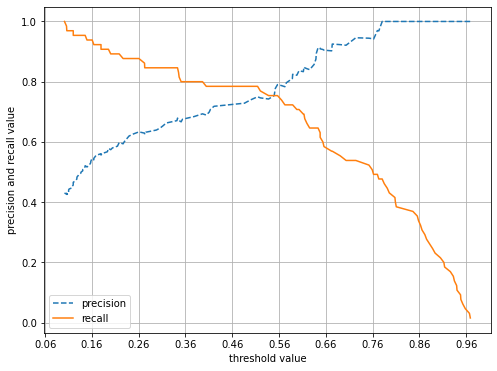

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 
    # 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', 
             label="precision")
    plt.plot(thresholds, recalls[0:threshold_boundary], label="recall")
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel("threshold value")
    plt.ylabel("precision and recall value")
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, pred_proba_class1)